In [43]:
import pickle
import pandas as pd
import os
import sys
sys.path
from scipy import stats
sys.path.append('../simulation')
import TS_personal_params_pooled as pp
import TS_global_params_pooled as gtp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
with open('../../Downloads/regret_818twoshortpositive.pkl','rb') as f:
    t = pickle.load(f)
    


EOFError: Ran out of input

In [9]:
def get_regret(p):
    to_return={}
    for time,dicts in p.items():
        for person,sims in dicts.items():
            if person not in to_return:
                to_return[person]={}
            for sim,r in sims.items():
                if time not in to_return[person]:
                    to_return[person][time]=[]
                to_return[person][time].append(r)
                
    for person in to_return:
        #for sim in to_return[person]:
            to_return[person]={t:np.array(to_return[person][t]).mean() for t in sorted(to_return[person])}
                
    return to_return

In [29]:
test = get_regret(t['case_three'])

In [13]:
def to_days(person):
    tr = {}
    for time,regret in person.items():
        date = time.date()
        if date not in tr:
                tr[date]=[]
        tr[date].append(regret)
    return [np.array(tr[t]).mean() for t in sorted(tr)]

In [19]:
def alls(d):
    big = []
    for person,values in d.items():
        big.append(to_days(values))
    return np.array(big).mean(axis=0)

In [30]:
testt = alls(test)

In [31]:
testt[-14:-7].mean()

0.0724744899366704

In [32]:
testt[-7:].mean()

0.07233060382482612

In [71]:
def get_all_three(ty):
    to_return={}
    for case in ['case_one','case_two','case_three']:
        tt= get_results_new_save_person('../../Downloads/pooling_results_testing/{}/'.format(ty),'32',7,case,'burden818twotimesaveshortmajority','inc')
        to_return[case]=tt
    return to_return

In [28]:
def get_results_new_save_person(results_path,pop_size,update_time,case,phrase,ophrase):
    
    
    files = os.listdir('{}{}'.format(results_path,case))
    
    steps = []

    #check population and pop_size,update_time
    files = [f for f in files if '.DS' not in f and pop_size in f and phrase in f and ophrase not in f and 'update_days_{}'.format(update_time) in f  and '2015' not in f    ]
    #files = files[:50]
    #print(len(files))
    #print(files)
    seen = 0 
    to_return = {}
    for ff in files:
        sim = int(ff.split('sim_')[1].split('_')[0])
        
        #try:
        with open('{}{}/{}'.format(results_path,case,ff),'rb') as f:
            d = pickle.load(f)
     
            #print(d.keys())
            if len(d)>0:
                to_return[sim]=d['pregret']
    to_save = {}
    for sim in range(50):
        for person in range(32):
            for time,regret in to_return[sim][person].items():
                if time not in to_save:
                    to_save[time]={}
                if person not in to_save[time]:
                    to_save[time][person]={}
                to_save[time][person][sim]=regret
    return to_save


In [38]:
tt= get_results_new_save_person('../../Downloads/pooling_results_testing/batch/','32',7,'case_three','burden818twotimesaveshortnegative','inc')


In [67]:
batch = get_all_three('batch')

In [72]:
personalized = get_all_three('batch')

In [40]:
rbatch = get_regret(tt)

In [41]:
testbatch = alls(rbatch)

In [46]:
def get_weekly_averages(points):
    to_return = []
    sems = []
    for i in range(0,len(points)-7,7):
        temp = points[i:i+7]
        to_return.append(np.array(temp).mean())
        #print(temp)
        sems.append(stats.sem(temp))
    return to_return,sems

In [69]:
def plot_all_special_regret(batch,personalized,pooled,hob,hobwrong,pn):
    
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.tight_layout( w_pad=2.5, h_pad=1.0)

    #'case_one','case_two',
    cases = ['case_one','case_two','case_three']
    plt.setp(ax[:],  yticks = np.arange(.4, .85, step=0.10),ylim = [.4,.85])
    #plt.setp(ax[1,:],  yticks = np.arange(0, .5, step=0.05),ylim = [0,.5])
    #'Homogenous','Bi-modal',
    
    titles = ['Homogenous','Bi-modal','Smooth']
    offset = 5
    for i in range(len(cases)):
            if i==0:
                plt.setp(ax[0],  yticks = np.arange(0.00, .25, step=0.05),ylim = [0.04,.23])
                ax[i].set_ylabel('Average weekly regret')
            if i==1:
                
                plt.setp(ax[1],  yticks = np.arange(0.00, .25, step=0.05),ylim = [0.04,.23])
                ax[i].set_xlabel('Decision times')
            if i==2:
                plt.setp(ax[2],  yticks = np.arange(0.05, .25, step=0.05),ylim = [0.04,.23])
            ax[i].set_title(titles[i])
            
            b =get_weekly_averages(alls(get_regret(batch[cases[i]])))
            #print(b)
            #labels = ['{}'.format(i) for i in range(0,len(b),15) ]
            #yerr=b[1],
            #[i for i in range(len(b[0]))],
            ax[i].errorbar([i for i in range(len(b[0]))],b[0],yerr=b[1],fmt='o-',label='Complete-pooling')
            
            #print(len([b[j] for j in range(0,len(b),25)]))
          
            p =get_weekly_averages(alls(get_regret(personalized[cases[i]])))
            #yerr=p[1],
            #[i for i in range(len(p[0]))]
            ax[i].errorbar([i for i in range(len(p[0]))],p[0],yerr=p[1],fmt='+-',label='Person-specific')
         
            po =get_weekly_averages(alls(get_regret(pooled[cases[i]])))
            #print(po)
            #yerr=po[1],
            ax[i].errorbar([i for i in range(len(po[0]))],po[0],yerr=po[1],label='IntelligentPooling')
            
            
            #h =get_weekly_averages(hob[cases[i]]['oregrets'])
            #print(po)
            #yerr=po[1],
            #ax[i].errorbar([i for i in range(len(h[0]))],h[0],yerr=h[1],label='HOB-Correct')
            
            
            #h =get_weekly_averages(hobwrong[cases[i]]['regrets'])
            #print(po)
            #yerr=po[1],
            #ax[i].errorbar([i for i in range(len(h[0]))],h[0],yerr=h[1],label='HOB-Incorrect')
            
            #xx=[i for i in range(int(len([b[j] for j in range(0,len(b),offset)])/4),len([b[j] for j in range(0,len(b),offset)]),int(len([b[j] for j in range(0,len(b),offset)])/4))]
            #print(xx)
            #print([j for j in range(0,len(b),offset)])
            xx = [i for i in range(0,8,2)]
            labels = ['{}'.format(i) for i in range(0,8,2) ]
            #labels = ['{}'.format(i*offset) for i in xx ]
            
            #print(labels)
            #print(xx)
            #print(len(labels))
            #print(len(xx))
            ax[i].set_xticks(xx)
            ax[i].set_xticklabels(labels)
    plt.legend(bbox_to_anchor=(1.15, .5)) 
    #plt.savefig('temp_plots/regret_trial_number_staggered_{}.pdf'.format(pn),dpi=300, bbox_inches='tight',)
    
    

In [65]:
test

{0: {Timestamp('2015-07-27 13:00:00'): 0.2778221524134774,
  Timestamp('2015-07-27 15:00:00'): 0.1975110313296885,
  Timestamp('2015-07-27 17:00:00'): 0.040560897252982,
  Timestamp('2015-07-27 19:00:00'): 0.05601266763507039,
  Timestamp('2015-07-28 10:00:00'): 0.3175110313296885,
  Timestamp('2015-07-28 13:00:00'): 0.3307406576350922,
  Timestamp('2015-07-28 15:00:00'): 0.41580729438372527,
  Timestamp('2015-07-28 19:00:00'): 0.04261675832015057,
  Timestamp('2015-07-29 13:00:00'): 0.49965916285670686,
  Timestamp('2015-07-29 15:00:00'): 0.3057406576350922,
  Timestamp('2015-07-29 17:00:00'): 0.046355311146265156,
  Timestamp('2015-07-30 10:00:00'): 0.4651999102458996,
  Timestamp('2015-07-30 15:00:00'): 0.052149725039548296,
  Timestamp('2015-07-30 17:00:00'): 0.1975110313296885,
  Timestamp('2015-07-30 19:00:00'): 0.39134804177291793,
  Timestamp('2015-07-31 10:00:00'): 0.1871497250395483,
  Timestamp('2015-07-31 13:00:00'): 0.07035531114626513,
  Timestamp('2015-07-31 15:00:00'): 

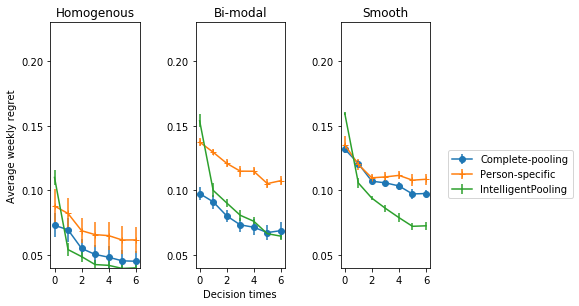

In [73]:
plot_all_special_regret(batch,personalized,t,{},{},'0')

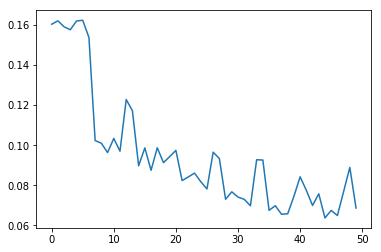

In [45]:
plt.plot(get_weekly_averages(testt)[0])